In [1]:
import os
import argparse
import logging
import sys

import torch
from torch.optim.lr_scheduler import StepLR
import torchtext

sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname(os.path.abspath(os.path.dirname('__file__'))))))

from trainer.supervised_trainer import SupervisedTrainer
from trainer.supervised_trainer_unmatching import SupervisedTrainer_unmatching
from models.encoderRNN_lenemb_add import EncoderRNN_lenemb_add
from models.decoderRNN_lenemb_add import DecoderRNN_lenemb_add
from models.encoderRNN import EncoderRNN
from models.decoderRNN import DecoderRNN
from models.seq2seq import Seq2seq
from loss.loss import Perplexity
from optim.optim import Optimizer
from dataset import fields
from evaluator.predictor import Predictor

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.decomposition import PCA
import numpy as np

from sklearn.manifold import TSNE
from collections import deque
import math

/home/hyeontae/hyeontae/venv/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/home/hyeontae/hyeontae/venv/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [2]:
train_path = "../../data/palindrome_rand/correction_single_Ctype4/data_train.txt"
log_path = "../../log/pth/train_palindrome_rand_correction_ctype4_single_Ctype4_model_save.pth"

In [3]:
LOG_FORMAT = '%(asctime)s %(name)-12s %(levelname)-8s %(message)s'
logging.basicConfig(format=LOG_FORMAT, level=getattr(logging, "info".upper()))

In [4]:
# Prepare dataset
src = fields.SourceField()
tgt = fields.TargetField()
max_len = 104
def len_filter(example):
    return len(example.src) <= max_len and len(example.tgt) <= max_len
train = torchtext.data.TabularDataset(
    path=train_path, format='tsv',
    fields=[('src', src), ('tgt', tgt)],
    filter_pred=len_filter
)

In [5]:
src.build_vocab(train)
tgt.build_vocab(train)
input_vocab = src.vocab
output_vocab = tgt.vocab

In [6]:
# Prepare loss
weight = torch.ones(len(tgt.vocab))
pad = tgt.vocab.stoi[tgt.pad_token]
loss = Perplexity(weight, pad)
if torch.cuda.is_available():
    loss.cuda()

seq2seq = None
seq2seq_no = None
optimizer = "Adam"
hidden_size = 200
bidirectional = False

/home/hyeontae/hyeontae/venv/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


# Initialize model Luong att

In [7]:
# Initialize model
encoder = EncoderRNN(len(src.vocab), max_len, hidden_size, n_layers=1,
                    bidirectional=bidirectional, variable_lengths=True, rnn_cell='lstm', context_vector=True)
decoder = DecoderRNN(len(tgt.vocab), max_len, hidden_size * 2 if bidirectional else hidden_size,
                    dropout_p=0.2, use_attention="Luong", bidirectional=bidirectional, rnn_cell='lstm',
                    eos_id=tgt.eos_id, sos_id=tgt.sos_id)
seq2seq = Seq2seq(encoder, decoder)
if torch.cuda.is_available():
    seq2seq.cuda()

for param in seq2seq.parameters():
    param.data.uniform_(-0.08, 0.08)

seq2seq.load_state_dict(torch.load(log_path))
seq2seq.eval()

predictor = Predictor(seq2seq, input_vocab, output_vocab)

/home/hyeontae/hyeontae/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:54: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


# Answer function

In [8]:
def answer_function(data):
    results = []
    words = data.split("#")
    comp = []
    for word in words:
        result = ""
        m = int(len(word)/2)
        for i in range(0,m):
            result += "0"
            comp.append(word[i])
        if len(word)%2 != 0:
            result += "0"
            m += 1
        for i in range(m,len(word)):
            w = comp.pop()
            if word[i] != w:
                if w == "a":
                    result += "1"
                elif w == "b":
                    result += "2"
                elif w == "c":
                    result += "3"
                elif w == "d":
                    result += "4"
                else:
                    result += "0"
            else:
                result += "0"
                
        results.append(result)

    return " ".join("0".join(results))

# Step function

In [9]:
def step_function(x):
    
    if x > 0:
        if x < 0.5:
            return 0
        else:
            return 1
    else:
        if x > -0.5:
            return 0
        else:
            return -1

# Predict

In [10]:
s = []
c = ["a", "b"]
for c1 in c:
    s.append(c1)
    for c2 in c:
        s.append(c1+c2)
        for c3 in c:
            s.append(c1+c2+c3)
            for c4 in c:
                s.append(c1+c2+c3+c4)
                for c5 in c:
                    s.append(c1+c2+c3+c4+c5)
                    for c6 in c:
                        s.append(c1+c2+c3+c4+c5+c6)
                        for c7 in c:
                            s.append(c1+c2+c3+c4+c5+c6+c7)
#                            for c8 in c:
#                                s.append(c1+c2+c3+c4+c5+c6+c7+c8)

/home/hyeontae/hyeontae/venv/lib/python3.6/site-packages/torch/nn/functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


[[ 1.41602699e-02  1.08594954e-01 -2.54060358e-01 ... -3.71841416e-02
  -5.15382886e-01  3.23037058e-02]
 [ 1.18498888e-03  4.61794734e-01  6.56709746e-02 ...  3.19047481e-01
  -5.19852936e-01  1.46407783e-01]
 [-9.46039055e-03  2.28259370e-01  2.01661319e-01 ...  7.19177350e-02
  -1.01086128e+00  5.50036728e-01]
 ...
 [-7.43454516e-01 -1.16736197e+00  4.24623536e-03 ... -2.67474389e+00
   1.02368939e+00  2.69502664e+00]
 [-1.35892498e+00 -2.13067341e+00  5.80151333e-04 ... -3.66000462e+00
   1.06181479e+00  3.68643641e+00]
 [-1.53470945e+00 -2.09580016e+00  1.47356500e-03 ... -3.65952206e+00
   1.04938853e+00  3.68385363e+00]]
0, 0


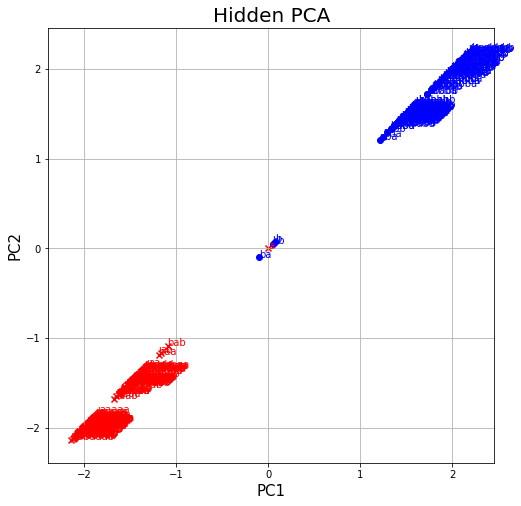

0, 1


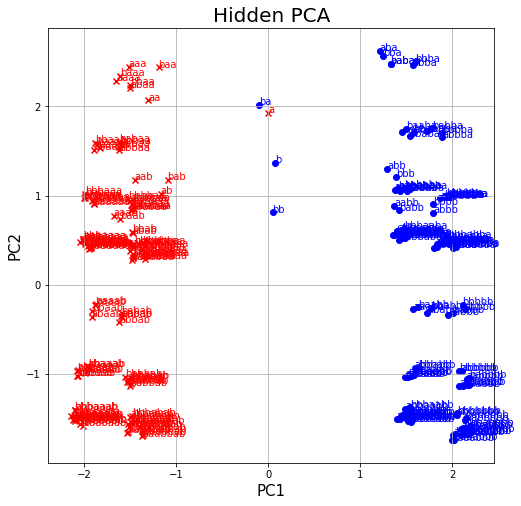

0, 2


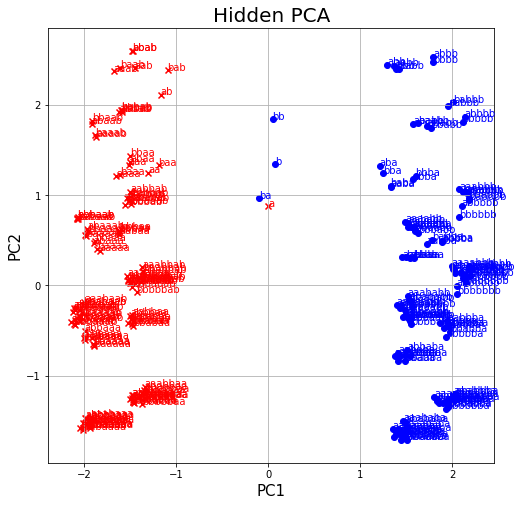

0, 3


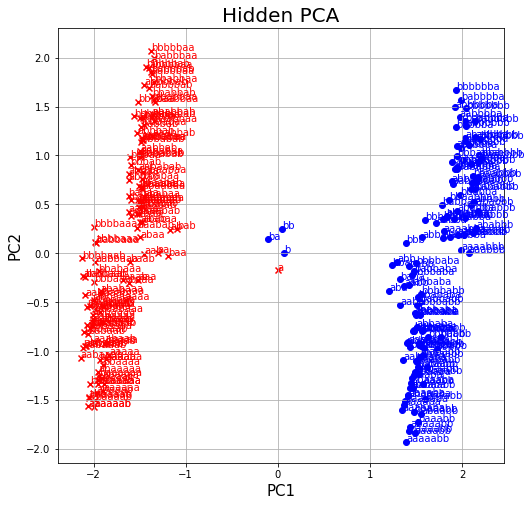

0, 4


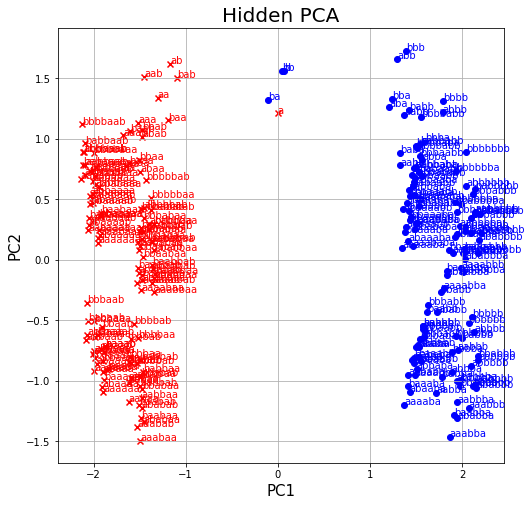

1, 0


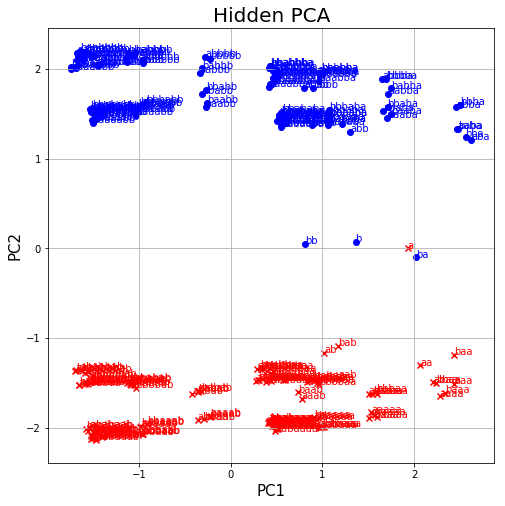

1, 1


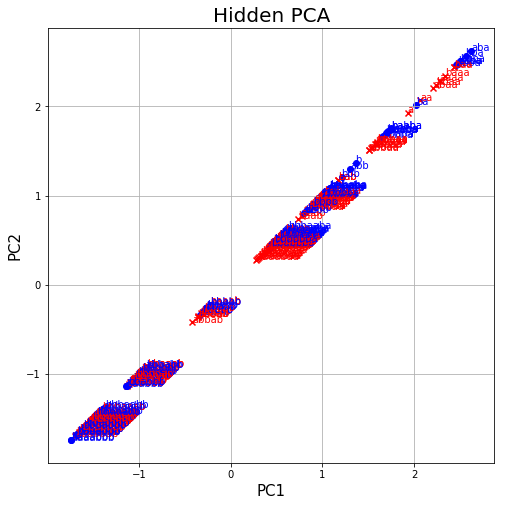

1, 2


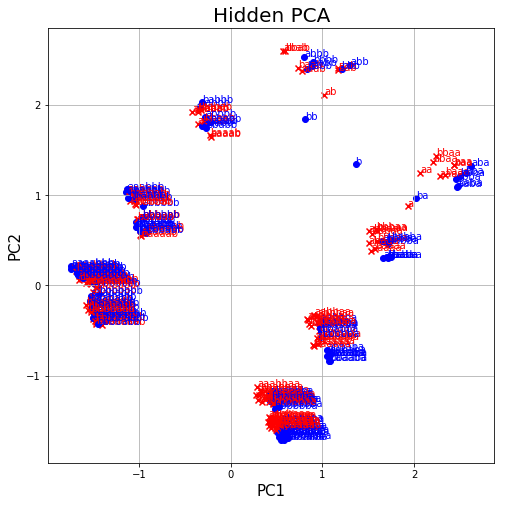

1, 3


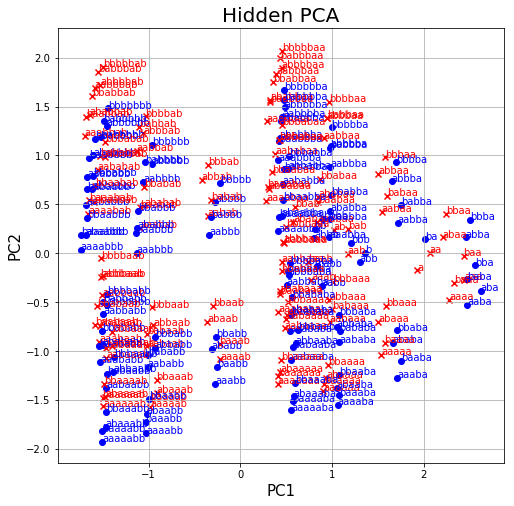

1, 4


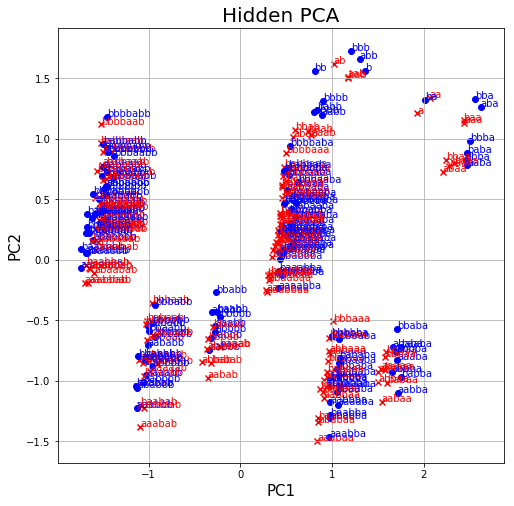

2, 0


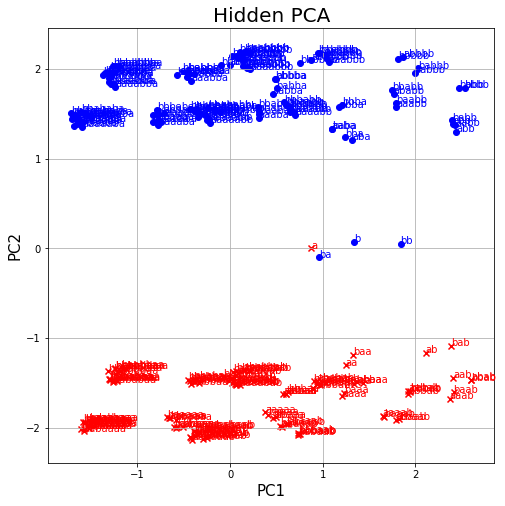

2, 1


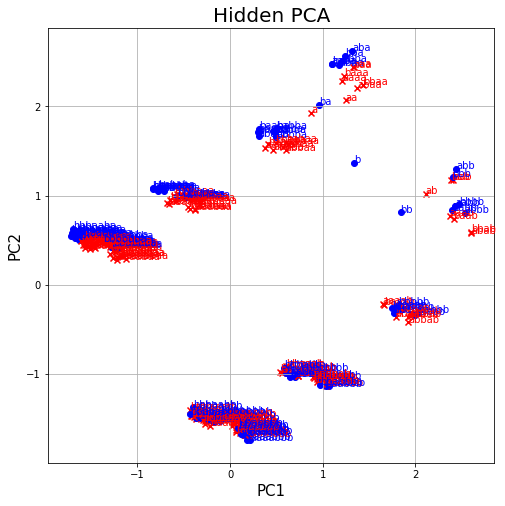

2, 2


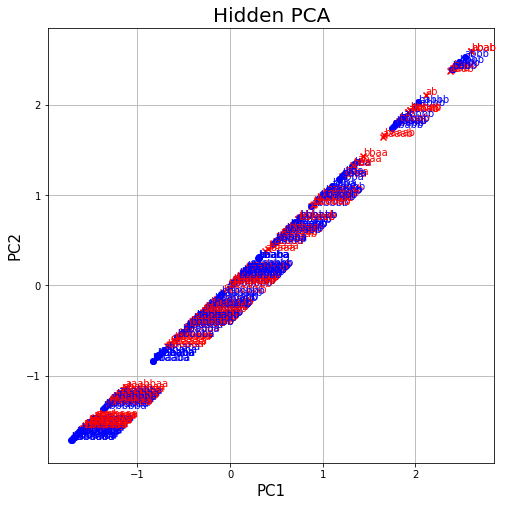

2, 3


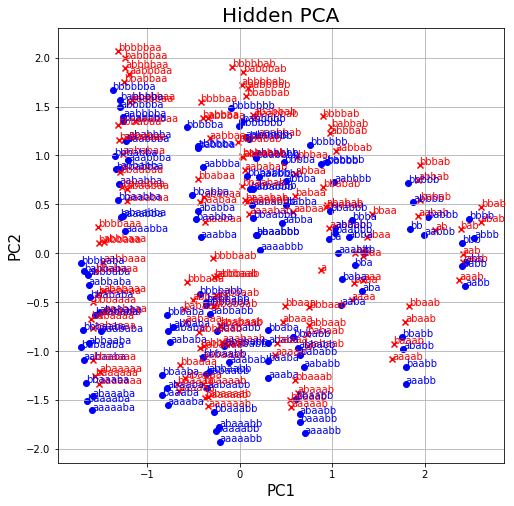

2, 4


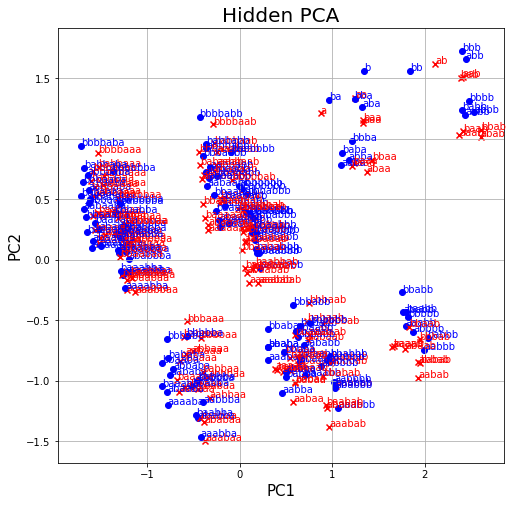

3, 0


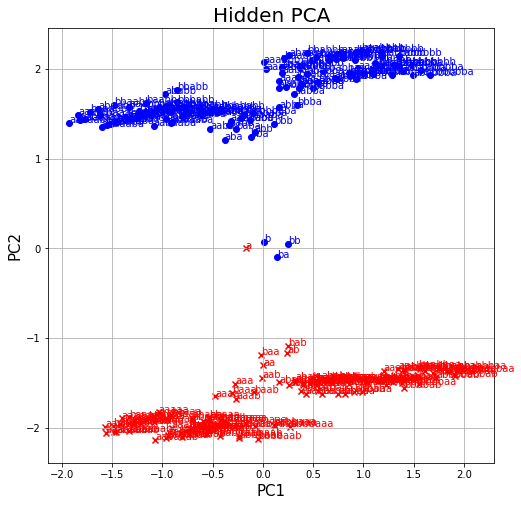

3, 1


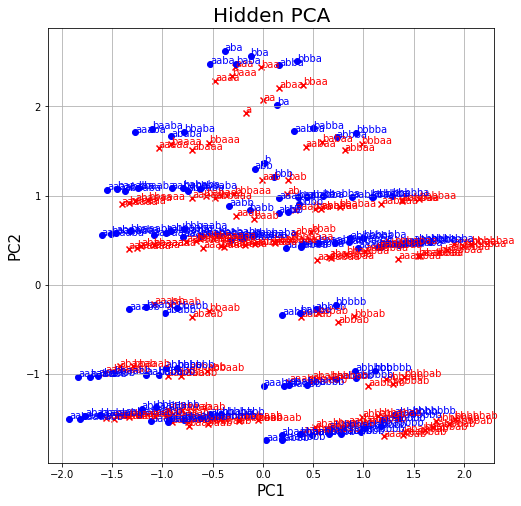

3, 2


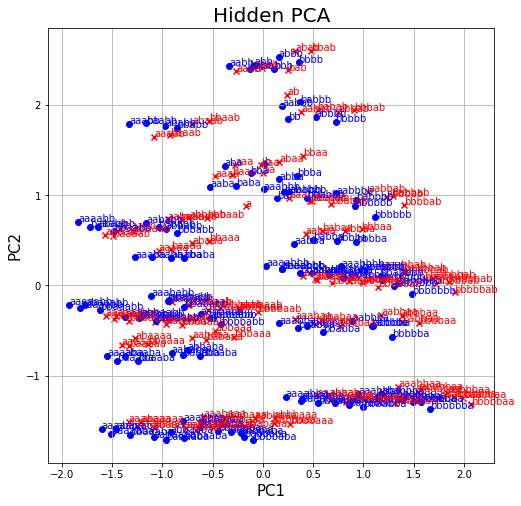

3, 3


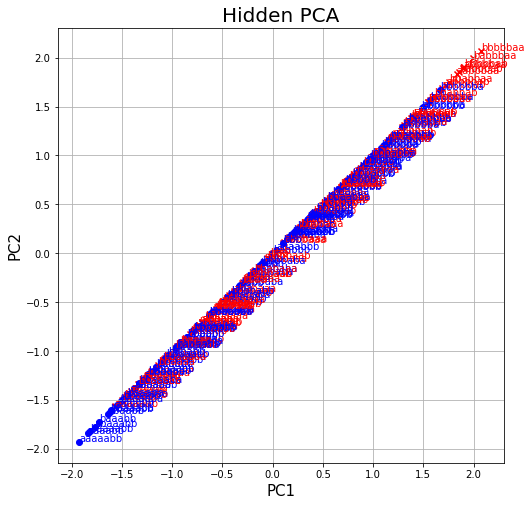

3, 4


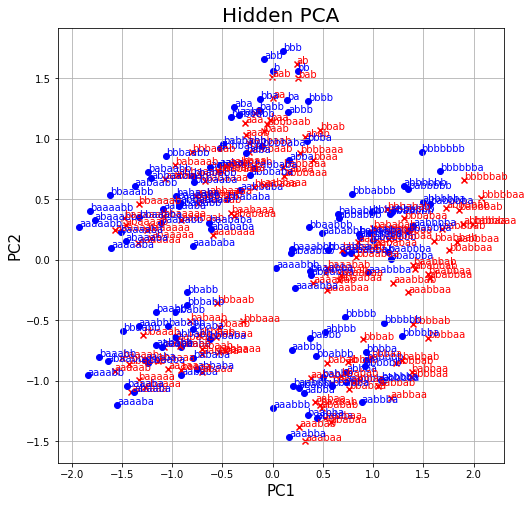

4, 0


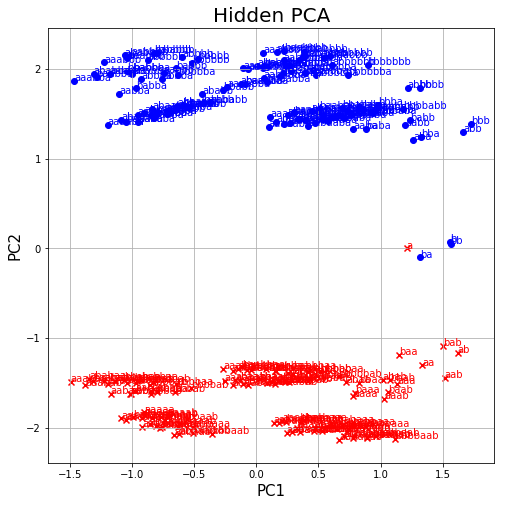

4, 1


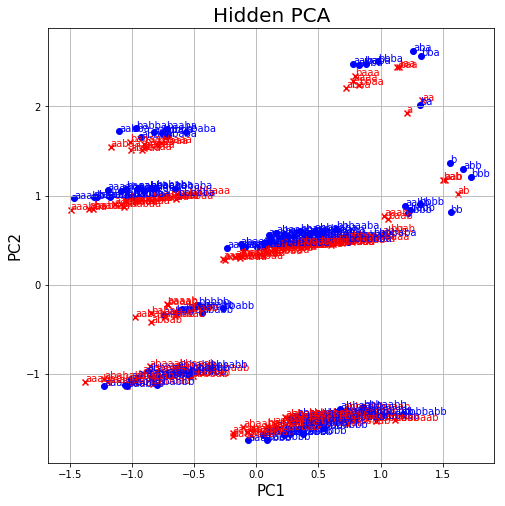

4, 2


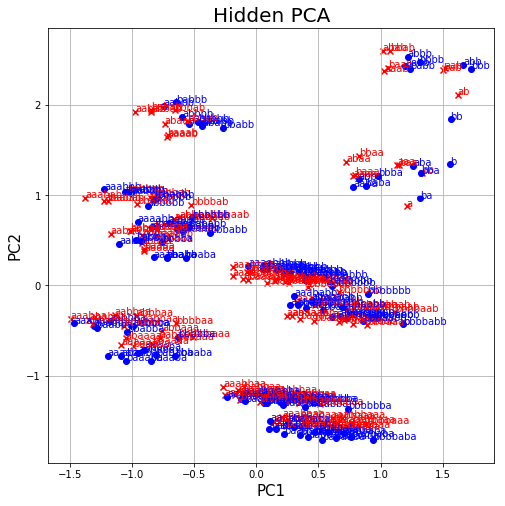

4, 3


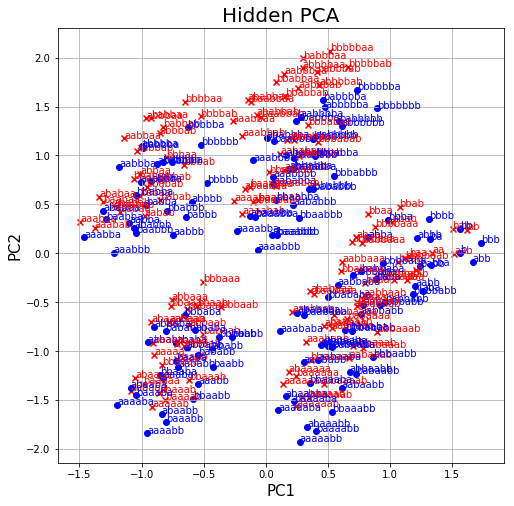

4, 4


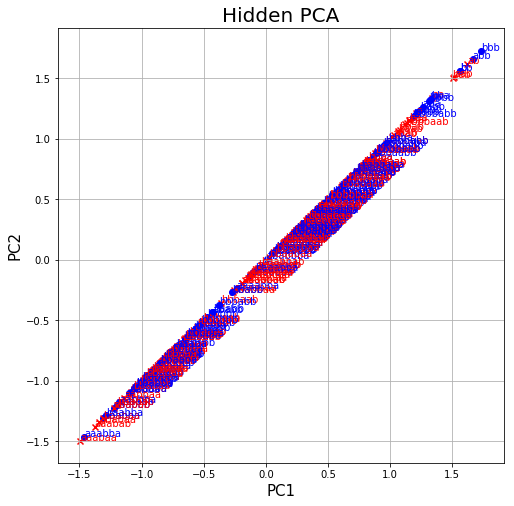

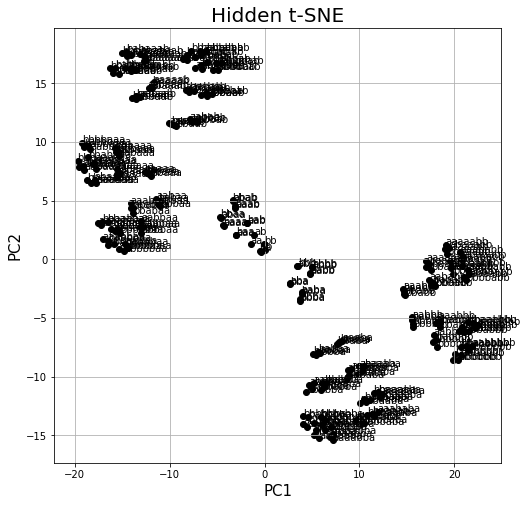

0, 0


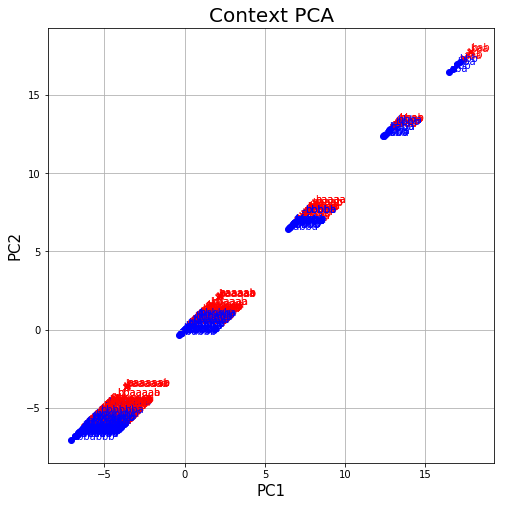

0, 1


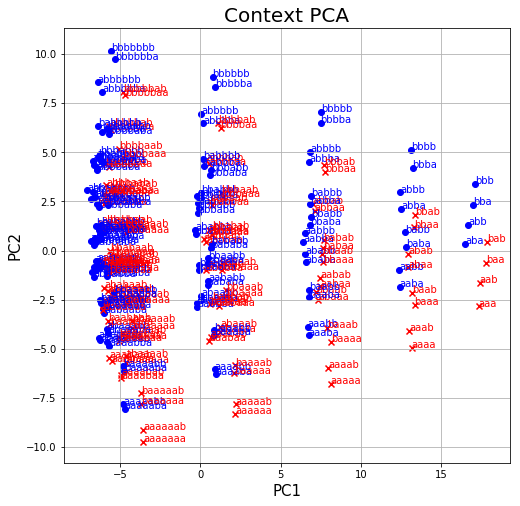

0, 2


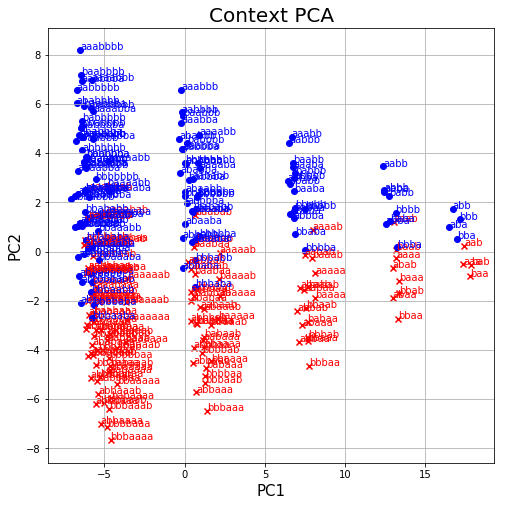

0, 3


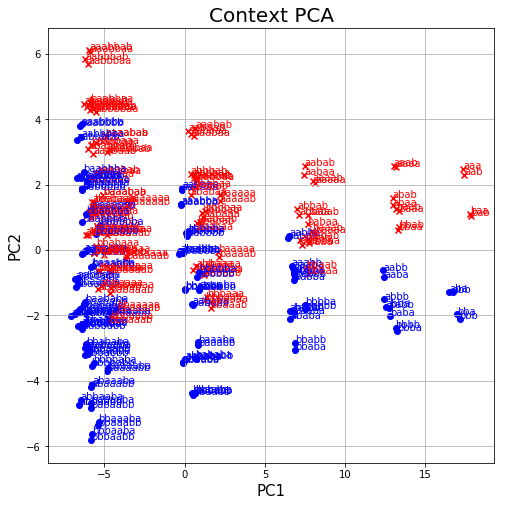

0, 4


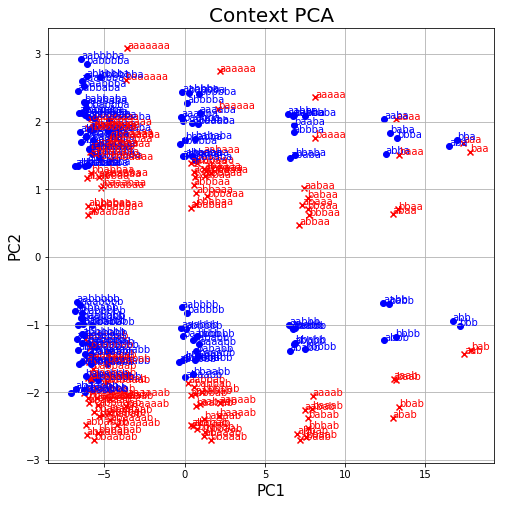

1, 0


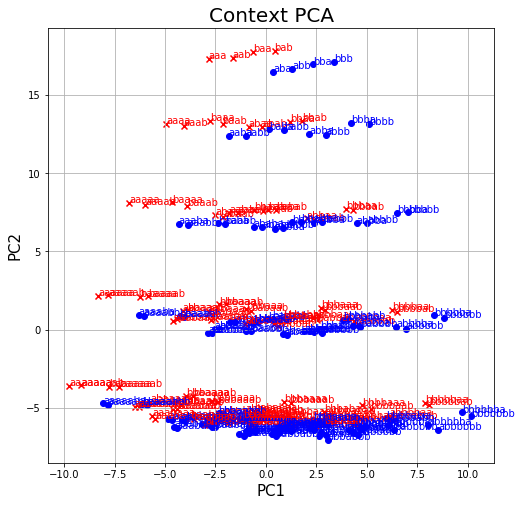

1, 1


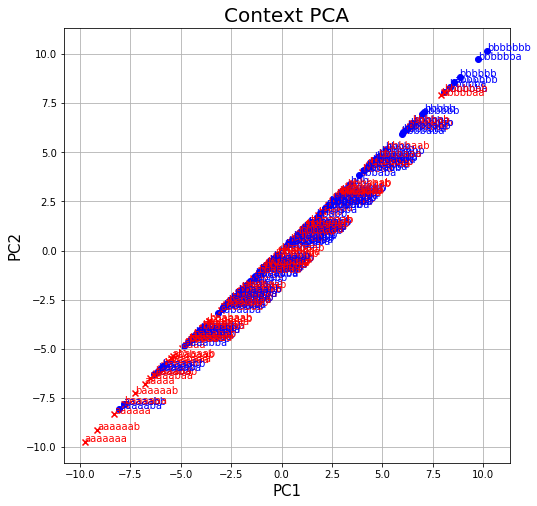

1, 2


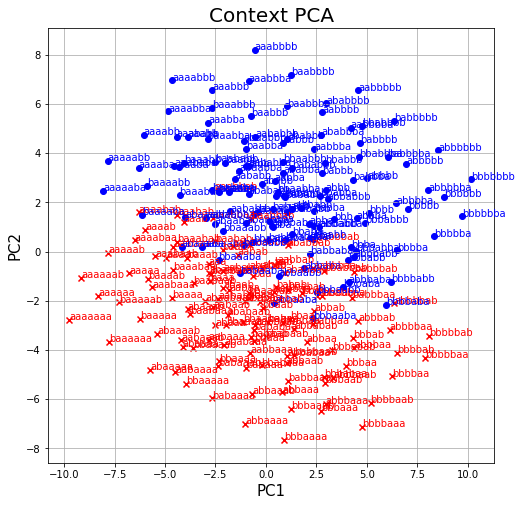

1, 3


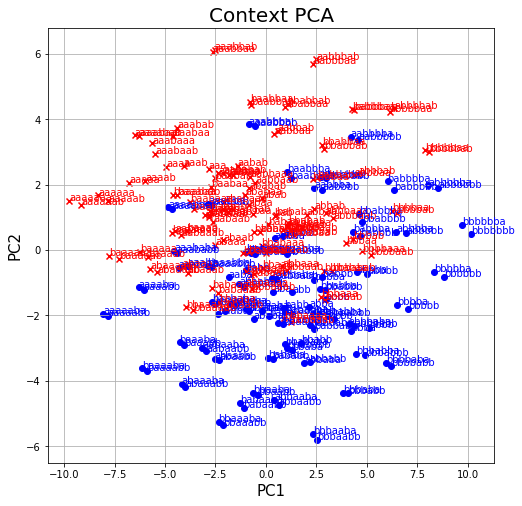

1, 4


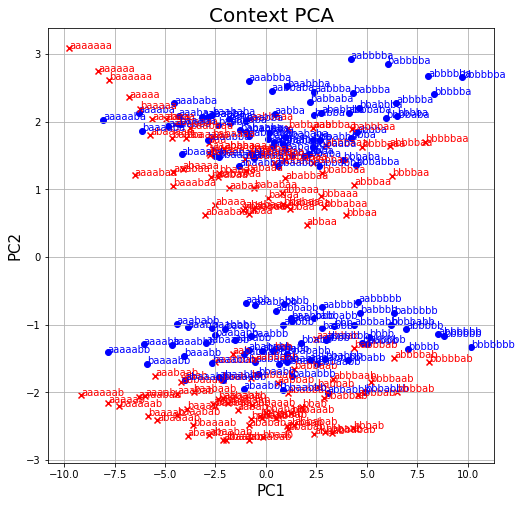

2, 0


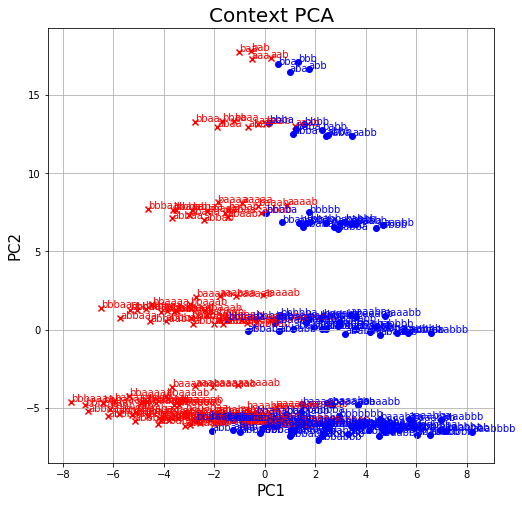

2, 1


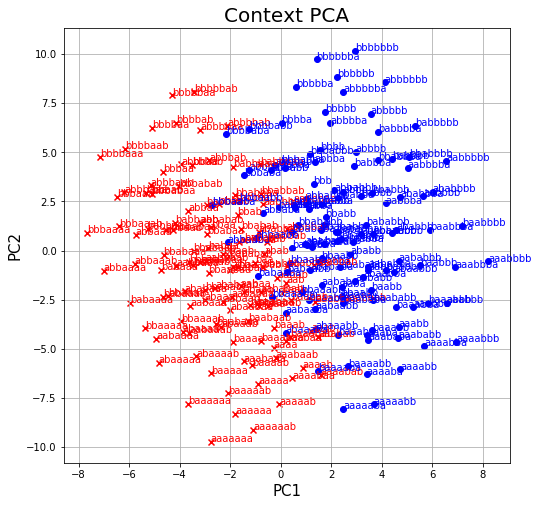

2, 2


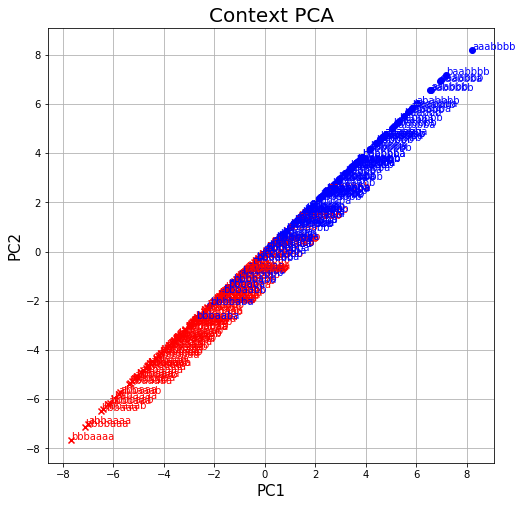

2, 3


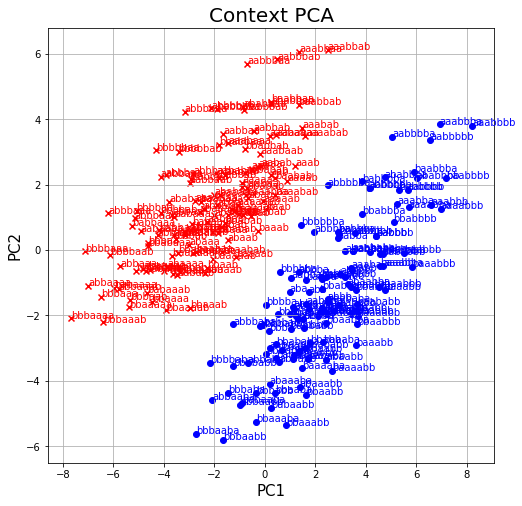

2, 4


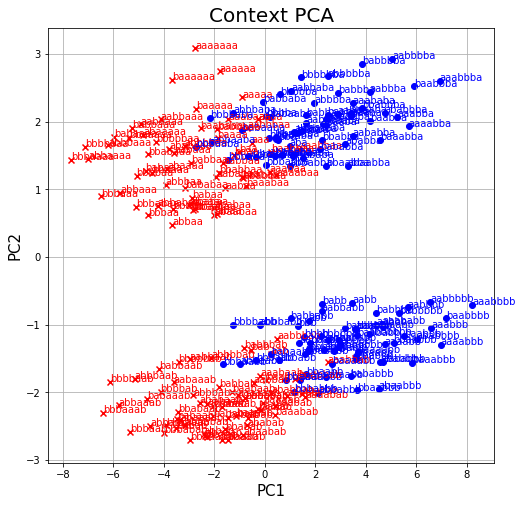

3, 0


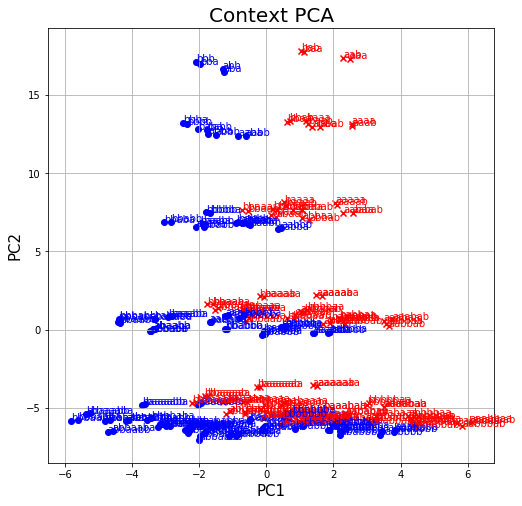

3, 1


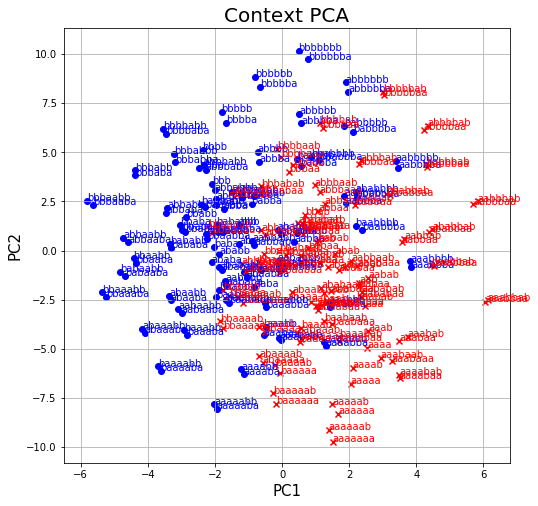

3, 2


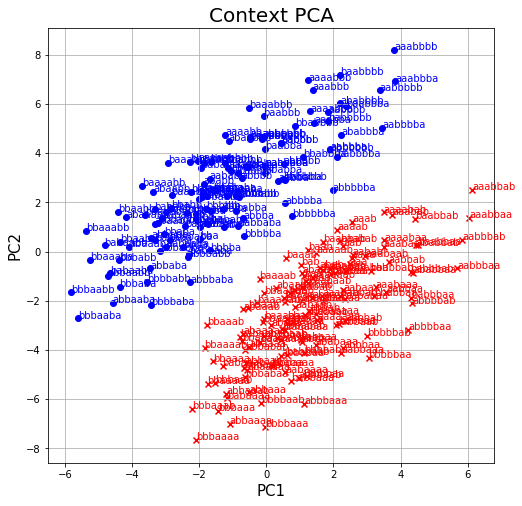

3, 3


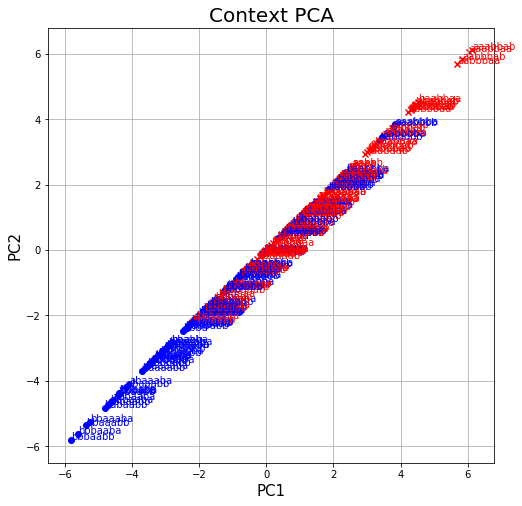

3, 4


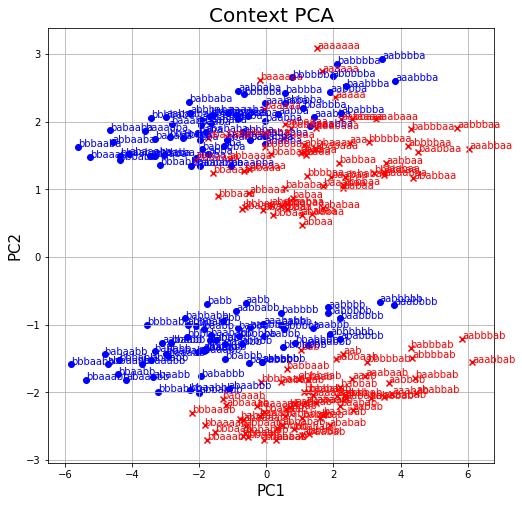

4, 0


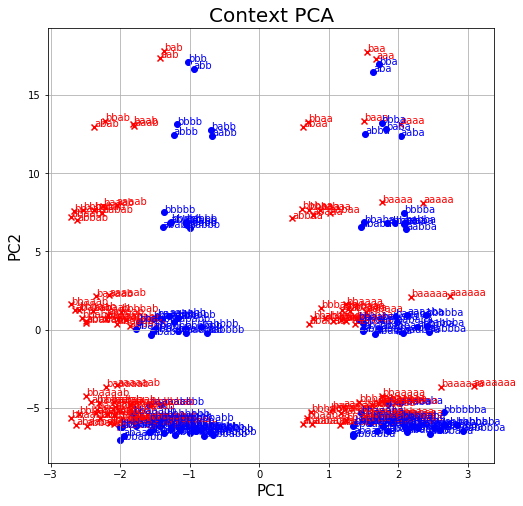

4, 1


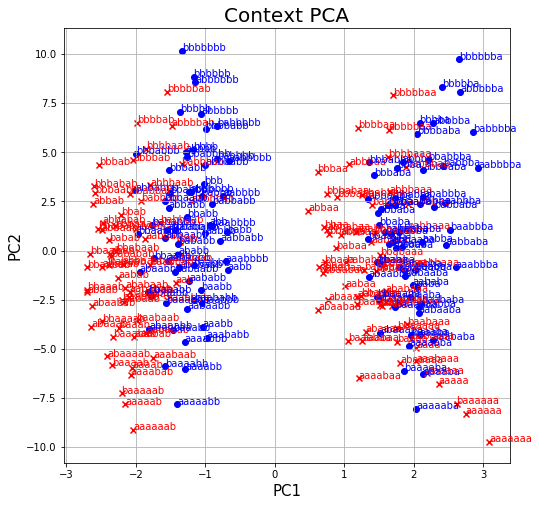

4, 2


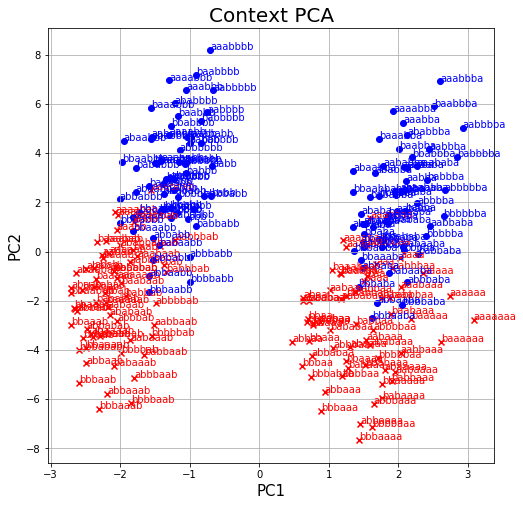

4, 3


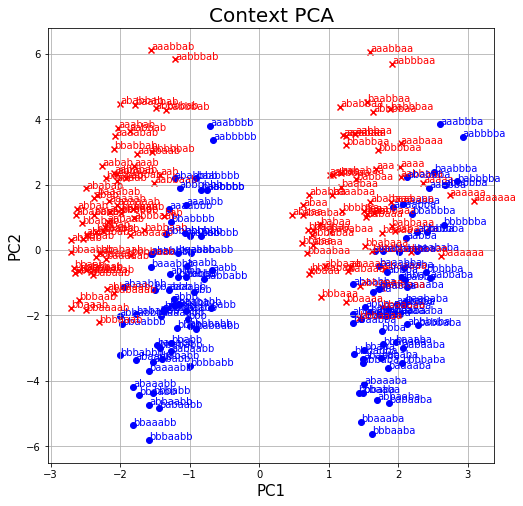

4, 4


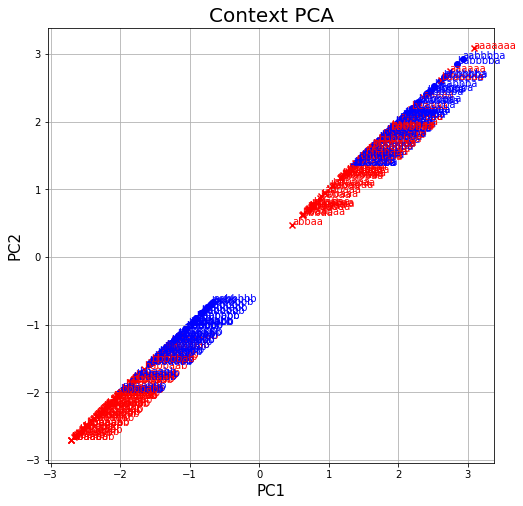

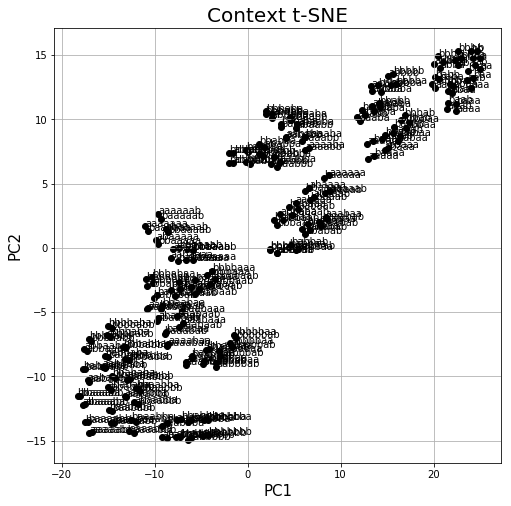

In [11]:
try:
    inputs = []
    encoder_outputs = []
    encoder_contexts = []

    for i in s:
        seq_str = i
        #seq_str = input("input : ")
        if seq_str == 'q':
            break
        
        seq = "".join(seq_str.strip().split())
        tgt_seq, tgt_att_list, encoder_output, encoder_context = predictor.predict(seq)
        #print("Answer: " + answer_function(seq))
        #print("Luong : " + " ".join(tgt_seq))
        
        inputs.append(seq)
        encoder_outputs.append(encoder_output.tolist().pop())
        if encoder_context is not None:
            encoder_contexts.append(encoder_context.tolist().pop())
        
    encoder_outputs = np.array(encoder_outputs)
    encoder_contexts = np.array(encoder_contexts)
    print(encoder_contexts)
    
    
    #---------Hidden PCA-----------------------------------------------------------------------------------
    pca_dim = 5
    principalComponents = PCA(n_components=pca_dim)
    pca = principalComponents.fit_transform(encoder_outputs)

    for first in range(pca_dim):
        for second in range(pca_dim):
            print(str(first) + ", " + str(second))
            fig2 = plt.figure(figsize=(8,8))
            ax2 = fig2.add_subplot(111)
            ax2.set_xlabel('PC1', fontsize = 15)
            ax2.set_ylabel('PC2', fontsize = 15)
            ax2.set_title('Hidden PCA', fontsize = 20)
            for j,i in zip(s,range(len(pca))):
                if len(j) == 1 or len(j) == 2:
                    if j[0] == 'a':
                        ax2.scatter(pca[i][first], pca[i][second], c='r', marker='x')
                        ax2.annotate(inputs[i],(pca[i][first], pca[i][second]), color='r')
                    elif j[0] == 'b':
                        ax2.scatter(pca[i][first], pca[i][second], c='b')
                        ax2.annotate(inputs[i],(pca[i][first], pca[i][second]), color='b')
                    continue
                if j[-2] == 'a':
                    ax2.scatter(pca[i][first], pca[i][second], c='r', marker='x')
                    ax2.annotate(inputs[i],(pca[i][first], pca[i][second]), color='r')
                elif j[-2] == 'b':
                    ax2.scatter(pca[i][first], pca[i][second], c='b')
                    ax2.annotate(inputs[i],(pca[i][first], pca[i][second]), color='b')
            #ax2.legend(bbox_to_anchor=(1, 1))
            ax2.grid()
            plt.show()
    #---------Hidden t-SNE---------------------------------------------------------------------------------
    tsne = TSNE(learning_rate=100)
    transformed = tsne.fit_transform(encoder_outputs)
    fig111 = plt.figure(figsize=(8,8))
    ax111 = fig111.add_subplot(111)
        
    ax111.set_xlabel('PC1', fontsize = 15)
    ax111.set_ylabel('PC2', fontsize = 15)
    ax111.set_title('Hidden t-SNE', fontsize = 20)
    for i in range(len(transformed)):
        ax111.scatter(transformed[i][0], transformed[i][1], c='k')
        ax111.annotate(inputs[i],(transformed[i][0], transformed[i][1]), color='k')
    #ax2.legend(bbox_to_anchor=(1, 1))
    ax111.grid()
    plt.show()
        
    if len(encoder_contexts) is not 0:
        #---------Context PCA-----------------------------------------------------------------------------------
        pca2 = principalComponents.fit_transform(encoder_contexts)
    
        for first in range(pca_dim):
            for second in range(pca_dim):
                print(str(first) + ", " + str(second))
                fig222 = plt.figure(figsize=(8,8))
                ax222 = fig222.add_subplot(111)
                ax222.set_xlabel('PC1', fontsize = 15)
                ax222.set_ylabel('PC2', fontsize = 15)
                ax222.set_title('Context PCA', fontsize = 20)
                for j,i in zip(s,range(len(transformed))):
                    if len(j) == 1 or len(j) == 2:
                        if j[0] == 'a':
                            ax2.scatter(pca[i][first], pca[i][second], c='r', marker='x')
                            ax2.annotate(inputs[i],(pca[i][first], pca[i][second]), color='r')
                        elif j[0] == 'b':
                            ax2.scatter(pca[i][first], pca[i][second], c='b')
                            ax2.annotate(inputs[i],(pca[i][first], pca[i][second]), color='b')
                        continue
                    if j[-2] == 'a':
                        ax222.scatter(pca2[i][first], pca2[i][second], c='r', marker='x')
                        ax222.annotate(inputs[i],(pca2[i][first], pca2[i][second]), color='r')
                    elif j[-2] == 'b':
                        ax222.scatter(pca2[i][first], pca2[i][second], c='b')
                        ax222.annotate(inputs[i],(pca2[i][first], pca2[i][second]), color='b')
                #ax2.legend(bbox_to_anchor=(1, 1))
                ax222.grid()
                plt.show()
        
        #---------Context t-SNE---------------------------------------------------------------------------------
        transformed2 = tsne.fit_transform(encoder_contexts)
        fig333 = plt.figure(figsize=(8,8))
        ax333 = fig333.add_subplot(111)
        
        ax333.set_xlabel('PC1', fontsize = 15)
        ax333.set_ylabel('PC2', fontsize = 15)
        ax333.set_title('Context t-SNE', fontsize = 20)
        for i in range(len(transformed2)):
            ax333.scatter(transformed2[i][0], transformed2[i][1], c='k')
            ax333.annotate(inputs[i],(transformed2[i][0], transformed2[i][1]), color='k')
        #ax2.legend(bbox_to_anchor=(1, 1))
        ax333.grid()
        plt.show()
        
except KeyboardInterrupt:
    pass